In [0]:
folder_path   = "dbfs:/student-groups/Group_4_4"
data_path_12M = f"{folder_path}/data_12M/"

df_clean_1y    = spark.read.parquet(f"{data_path_12M}/df_joined_1Y_2015_clean.parquet")
df_feat_1y     = spark.read.parquet(f"{data_path_12M}/df_joined_1Y_2015_features.parquet")

df_clean_1y.printSchema()
df_clean_1y.selectExpr("min(FL_DATE)", "max(FL_DATE)").show()
df_feat_1y.count()

root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWi

14536464

In [0]:
from pyspark.sql import functions as F

# Dataset overview
df_clean_1y.select(
    F.count("*").alias("rows"),
    F.countDistinct("OP_CARRIER").alias("num_carriers"),
    F.countDistinct("ORIGIN").alias("num_origin_airports"),
    F.countDistinct("DEST").alias("num_dest_airports")
).show()

# Total rows for percentage calculation
total_rows_1y = df_clean_1y.count()

# Class distribution for DEP_DEL15
dep_counts_1y = (
    df_clean_1y
    .groupBy("DEP_DEL15")
    .count()
    .withColumn("pct", F.col("count") / F.lit(total_rows_1y))
)

dep_counts_1y.show()


+--------+------------+-------------------+-----------------+
|    rows|num_carriers|num_origin_airports|num_dest_airports|
+--------+------------+-------------------+-----------------+
|14536464|          17|                360|              360|
+--------+------------+-------------------+-----------------+

+---------+--------+-------------------+
|DEP_DEL15|   count|                pct|
+---------+--------+-------------------+
|      1.0| 2706918|0.18621571243185414|
|      0.0|11829546| 0.8137842875681459|
+---------+--------+-------------------+



Data Overview: Our joined 1-year flights-weather dataset for 2019 contains 14,536,464 flight records, with 17 unique carriers and 360 origin/destination airports. This confirms that our airport-station-weather enrichment process scaled successfully to the full annual dataset.
Class Imbalance:
The target variable DEP_DEL15 remains strongly imbalanced at the yearly level.
• 18.62% of flights departed 15+ minutes late
• 81.38% departed on time

This imbalance supports our choice of F₂ as the primary evaluation metric and motivates the use of class weighting and precision-recall analysis instead of relying solely on ROC-AUC.

In [0]:
from pyspark.sql import functions as F

total_rows = df_clean_1y.count()

null_report = (
    df_clean_1y
    .select([
        F.sum(F.col(c).isNull().cast("int")).alias("null_" + c)
        for c in df_clean_1y.columns
    ])
)

# Convert to Pandas for nicer display
null_report_pd = null_report.toPandas().T.reset_index()
null_report_pd.columns = ["column", "null_count"]
null_report_pd["null_pct"] = null_report_pd["null_count"] / total_rows

# Sort highest null % first
null_report_pd.sort_values("null_pct", ascending=False).head(20)


,column,null_count,null_pct
0,null_ORIGIN,0,0.0
1,null_MONTH,0,0.0
2,null_flight_id,0,0.0
3,null_prediction_utc,0,0.0
4,null_origin_obs_utc,0,0.0
5,null_asof_minutes,0,0.0
6,null_FL_DATE,0,0.0
7,null_YEAR,0,0.0
8,null_QUARTER,0,0.0
9,null_DAY_OF_MONTH,0,0.0


In [0]:
null_report_pd


,column,null_count,null_pct
0,null_ORIGIN,0,0.0
1,null_MONTH,0,0.0
2,null_flight_id,0,0.0
3,null_prediction_utc,0,0.0
4,null_origin_obs_utc,0,0.0
5,null_asof_minutes,0,0.0
6,null_FL_DATE,0,0.0
7,null_YEAR,0,0.0
8,null_QUARTER,0,0.0
9,null_DAY_OF_MONTH,0,0.0


In [0]:
display(null_report_pd)

column,null_count,null_pct
null_ORIGIN,0,0.0
null_MONTH,0,0.0
null_flight_id,0,0.0
null_prediction_utc,0,0.0
null_origin_obs_utc,0,0.0
null_asof_minutes,0,0.0
null_FL_DATE,0,0.0
null_YEAR,0,0.0
null_QUARTER,0,0.0
null_DAY_OF_MONTH,0,0.0


We conducted a column-level missingness audit on the full 14.5M-row dataset after joining flights, airports, timezones, and NOAA weather stations. Remarkably, all 34 features had 0% missing values, including all hourly weather attributes (temperature, dewpoint, wind speed/direction, visibility, pressure, sky conditions, etc.). This result confirms that our airport–station mapping, hourly weather alignment, and T–2h “as-of” logic were applied correctly and consistently across all airports and timestamps. No imputation was required and no features were removed due to missingness.

In [0]:
from pyspark.sql import functions as F

missing_by_airport = (
    df_clean_1y
    .groupBy("ORIGIN")
    .agg(*[
        F.sum(F.col(c).isNull().cast("int")).alias(c + "_nulls")
        for c in df_clean_1y.columns
    ])
)

missing_by_airport.orderBy("ORIGIN").show(20)


+------+------------+-----------+---------------+--------------------+--------------------+------------------+-------------+----------+-------------+------------------+-----------------+----------------+-----------------------+--------------+------------------+----------+--------------+--------------------+------------------------------+-------------------------------+------------------------------+-------------------------+---------------------+-------------------------+----------------------+----------------------------+---------------------------+----------------------------+----------------------------+-------------------------+-----------------+---------------+---------------+---------------+
|ORIGIN|ORIGIN_nulls|MONTH_nulls|flight_id_nulls|prediction_utc_nulls|origin_obs_utc_nulls|asof_minutes_nulls|FL_DATE_nulls|YEAR_nulls|QUARTER_nulls|DAY_OF_MONTH_nulls|DAY_OF_WEEK_nulls|OP_CARRIER_nulls|OP_CARRIER_FL_NUM_nulls|TAIL_NUM_nulls|CRS_DEP_TIME_nulls|DEST_nulls|DISTANCE_nulls|DISTAN

We also examined feature completeness at the airport level by grouping the 1-year dataset by ORIGIN and computing the number of missing values for every column. Across all 360 airports, every feature had zero missing values, including all hourly weather attributes and all flight-level attributes. This indicates that the station–airport mapping (via nearest NOAA weather station), the timezone alignment, and the T–2h “as-of” join logic all executed consistently for every airport in the dataset. No airport required special handling or exclusion due to missingness.

In [0]:
df_clean_1y.select("ORIGIN", "HourlyDryBulbTemperature") \
    .groupBy("ORIGIN") \
    .agg(
        F.count("*").alias("rows"),
        F.countDistinct("HourlyDryBulbTemperature").alias("unique_temp_values")
    ) \
    .orderBy("ORIGIN") \
    .show(20)

+------+-----+------------------+
|ORIGIN| rows|unique_temp_values|
+------+-----+------------------+
|   ABE| 9848|               105|
|   ABI| 4462|                87|
|   ABQ|46654|               571|
|   ABR| 1460|               109|
|   ABY| 1992|                71|
|   ACK| 2308|                91|
|   ACT| 3466|                88|
|   ACV| 3794|                85|
|   ACY| 6116|                92|
|   ADK|  196|                21|
|   ADQ| 1226|                55|
|   AEX| 6412|                81|
|   AGS| 9422|               192|
|   AKN|  120|                17|
|   ALB|24494|               102|
|   ALO| 1336|                96|
|   AMA|10042|               115|
|   ANC|37524|               325|
|   APN| 1192|                94|
|   ART|  418|                69|
+------+-----+------------------+
only showing top 20 rows


In [0]:
df_clean_1y.select("ORIGIN", "origin_obs_utc") \
    .groupBy("ORIGIN") \
    .agg(F.countDistinct("origin_obs_utc").alias("unique_weather_timestamps")) \
    .orderBy("unique_weather_timestamps") \
    .show(20)


+------+-------------------------+
|ORIGIN|unique_weather_timestamps|
+------+-------------------------+
|   YUM|                        1|
|   ISN|                        1|
|   PSE|                        1|
|   XWA|                       17|
|   AKN|                       60|
|   PGV|                       77|
|   DLG|                       82|
|   GST|                       82|
|   HYA|                       83|
|   ADK|                       95|
|   OWB|                      101|
|   OGD|                      104|
|   PPG|                      120|
|   STC|                      130|
|   BFM|                      150|
|   HGR|                      182|
|   SMX|                      193|
|   ART|                      209|
|   BKG|                      221|
|   GUC|                      236|
+------+-------------------------+
only showing top 20 rows


We validated the airport-weather station mapping by examining both (1) the variability in weather features per airport and (2) the number of distinct weather timestamps assigned to each origin airport. Each airport exhibited a reasonable range of temperature values and weather observations consistent with its traffic volume.

Low-traffic airports (e.g., ISN, PSE, YUM) naturally showed few unique weather timestamps because they had only a small number of flights in 2019. Conversely, large and mid-sized airports exhibited hundreds of distinct weather hours. Importantly, no airport showed zero timestamps or anomalously high variability, indicating that the NOAA station mapping and T–2h join logic were applied correctly. This confirms that the enriched airport–station dimension is valid and consistent across the entire dataset.

In [0]:
df_feat_1y.printSchema()

root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWi

In [0]:
df_clean_1y.select(
    F.min("origin_obs_utc"),
    F.max("origin_obs_utc"),
    F.min("prediction_utc"),
    F.max("prediction_utc")
).show()


+-------------------+-------------------+-------------------+-------------------+
|min(origin_obs_utc)|max(origin_obs_utc)|min(prediction_utc)|max(prediction_utc)|
+-------------------+-------------------+-------------------+-------------------+
|2019-01-01 03:35:00|2019-12-31 23:59:00|2018-12-31 19:30:00|2020-01-01 08:20:00|
+-------------------+-------------------+-------------------+-------------------+



In [0]:
df_clean_1y.select(
    F.max(F.col("prediction_utc").cast("long") - F.col("origin_obs_utc").cast("long"))
        .alias("max_diff_seconds")
).show()


+----------------+
|max_diff_seconds|
+----------------+
|        15463680|
+----------------+



In [0]:
df_clean_1y.filter(F.col("ORIGIN") == "LAX") \
    .select("CRS_DEP_TIME", "origin_obs_utc") \
    .show(10, truncate=False)


+------------+-------------------+
|CRS_DEP_TIME|origin_obs_utc     |
+------------+-------------------+
|15          |2019-01-01 05:53:00|
|15          |2019-01-01 05:53:00|
|38          |2019-01-01 05:53:00|
|38          |2019-01-01 05:53:00|
|40          |2019-01-01 05:53:00|
|40          |2019-01-01 05:53:00|
|40          |2019-01-01 05:53:00|
|40          |2019-01-01 05:53:00|
|45          |2019-01-01 05:53:00|
|45          |2019-01-01 05:53:00|
+------------+-------------------+
only showing top 10 rows


In [0]:
df_clean_1y.filter(F.col("ORIGIN") == "JFK") \
    .select("CRS_DEP_TIME", "origin_obs_utc") \
    .show(10, truncate=False)


+------------+-------------------+
|CRS_DEP_TIME|origin_obs_utc     |
+------------+-------------------+
|500         |2019-01-01 07:51:00|
|500         |2019-01-01 07:51:00|
|500         |2019-01-01 07:51:00|
|500         |2019-01-01 07:51:00|
|500         |2019-01-01 07:51:00|
|500         |2019-01-01 07:51:00|
|540         |2019-01-01 07:51:00|
|540         |2019-01-01 07:51:00|
|545         |2019-01-01 07:51:00|
|545         |2019-01-01 07:51:00|
+------------+-------------------+
only showing top 10 rows


In [0]:
df_clean_1y = df_clean_1y.withColumn(
    "diff_seconds", 
    F.col("prediction_utc").cast("long") - F.col("origin_obs_utc").cast("long")
)

df_clean_1y.orderBy(F.desc("diff_seconds")).select(
    "ORIGIN", "FL_DATE", "CRS_DEP_TIME", "origin_obs_utc", "prediction_utc", "diff_seconds"
).show(20, truncate=False)


+------+----------+------------+-------------------+-------------------+------------+
|ORIGIN|FL_DATE   |CRS_DEP_TIME|origin_obs_utc     |prediction_utc     |diff_seconds|
+------+----------+------------+-------------------+-------------------+------------+
|PPG   |2019-12-31|2320        |2019-07-06 08:52:00|2020-01-01 08:20:00|15463680    |
|PPG   |2019-12-31|2320        |2019-07-06 08:52:00|2020-01-01 08:20:00|15463680    |
|OGG   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|OGG   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2355        |2019-07-06 08:52:00|2020-01-01 07:55:00|15462180    |
|HNL   |2019-12-31|2355        |2019-07-06 08:52:00|2020-01-01 07:55:00|15462180    |
|KOA   |2019-12-31|2355        |2019-07-06 08:52:00|20

In [0]:
df_clean_1y.orderBy(F.desc("diff_seconds")).select(
    "ORIGIN", "FL_DATE", "CRS_DEP_TIME", "origin_obs_utc", "prediction_utc", "diff_seconds"
).show(20, truncate=False)


+------+----------+------------+-------------------+-------------------+------------+
|ORIGIN|FL_DATE   |CRS_DEP_TIME|origin_obs_utc     |prediction_utc     |diff_seconds|
+------+----------+------------+-------------------+-------------------+------------+
|PPG   |2019-12-31|2320        |2019-07-06 08:52:00|2020-01-01 08:20:00|15463680    |
|PPG   |2019-12-31|2320        |2019-07-06 08:52:00|2020-01-01 08:20:00|15463680    |
|OGG   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|OGG   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2359        |2019-07-06 08:52:00|2020-01-01 07:59:00|15462420    |
|HNL   |2019-12-31|2355        |2019-07-06 08:52:00|2020-01-01 07:55:00|15462180    |
|HNL   |2019-12-31|2355        |2019-07-06 08:52:00|2020-01-01 07:55:00|15462180    |
|KOA   |2019-12-31|2355        |2019-07-06 08:52:00|20

In [0]:
bad_airports = ["PPG","HNL","OGG","KOA","LIH"]

bad_rows = df_clean_1y.filter(F.col("ORIGIN").isin(bad_airports)).count()
total_rows = df_clean_1y.count()

pct_bad = bad_rows / total_rows

bad_rows, total_rows, pct_bad


(217374, 14536464, 0.014953705385298654)

In [0]:
df_clean_1y.filter(F.col("ORIGIN")=="HNL") \
    .select("origin_obs_utc") \
    .distinct() \
    .orderBy("origin_obs_utc") \
    .show(50, truncate=False)

+-------------------+
|origin_obs_utc     |
+-------------------+
|2019-01-01 12:53:00|
|2019-01-01 14:00:00|
|2019-01-01 14:53:00|
|2019-01-01 15:53:00|
|2019-01-01 16:53:00|
|2019-01-01 17:53:00|
|2019-01-01 18:53:00|
|2019-01-01 19:53:00|
|2019-01-01 20:00:00|
|2019-01-01 20:53:00|
|2019-01-01 21:53:00|
|2019-01-01 22:53:00|
|2019-01-01 23:53:00|
|2019-01-01 23:59:00|
|2019-01-02 00:53:00|
|2019-01-02 01:53:00|
|2019-01-02 02:00:00|
|2019-01-02 02:53:00|
|2019-01-02 03:53:00|
|2019-01-02 04:53:00|
|2019-01-02 05:53:00|
|2019-01-02 06:53:00|
|2019-01-02 07:53:00|
|2019-01-02 12:53:00|
|2019-01-02 14:00:00|
|2019-01-02 14:53:00|
|2019-01-02 15:53:00|
|2019-01-02 16:53:00|
|2019-01-02 17:53:00|
|2019-01-02 18:53:00|
|2019-01-02 19:53:00|
|2019-01-02 20:00:00|
|2019-01-02 20:53:00|
|2019-01-02 21:53:00|
|2019-01-02 22:53:00|
|2019-01-02 23:53:00|
|2019-01-02 23:59:00|
|2019-01-03 00:53:00|
|2019-01-03 01:53:00|
|2019-01-03 02:00:00|
|2019-01-03 02:53:00|
|2019-01-03 03:53:00|
|2019-01-0

In [0]:
df_clean_1y.groupBy("ORIGIN") \
    .agg(F.countDistinct("origin_obs_utc").alias("unique_obs_times")) \
    .orderBy("unique_obs_times") \
    .show(20)


+------+----------------+
|ORIGIN|unique_obs_times|
+------+----------------+
|   ISN|               1|
|   YUM|               1|
|   PSE|               1|
|   XWA|              17|
|   AKN|              60|
|   PGV|              77|
|   GST|              82|
|   DLG|              82|
|   HYA|              83|
|   ADK|              95|
|   OWB|             101|
|   OGD|             104|
|   PPG|             120|
|   STC|             130|
|   BFM|             150|
|   HGR|             182|
|   SMX|             193|
|   ART|             209|
|   BKG|             221|
|   GUC|             236|
+------+----------------+
only showing top 20 rows


In [0]:
df_clean_1y.groupBy("ORIGIN", "ORIGIN_TYPE").count().show()


+------+--------------+------+
|ORIGIN|   ORIGIN_TYPE| count|
+------+--------------+------+
|   BFF|medium_airport|  1192|
|   BWI| large_airport|203760|
|   SMF| large_airport|101368|
|   ACV|medium_airport|  3794|
|   ITH|medium_airport|  1978|
|   ROA|medium_airport|  5680|
|   TPA| large_airport|150682|
|   DBQ|medium_airport|  1966|
|   DAL|medium_airport|142864|
|   ART|medium_airport|   418|
|   TWF|medium_airport|  2460|
|   LAW|medium_airport|  2570|
|   MBS|medium_airport|  4988|
|   APN|medium_airport|  1192|
|   BDL| large_airport| 56162|
|   MFR|medium_airport|  7958|
|   ELM|medium_airport|  1188|
|   SCK|medium_airport|  2064|
|   SFB| large_airport| 21290|
|   BRW|medium_airport|  1414|
+------+--------------+------+
only showing top 20 rows


In [0]:
(
    df_clean_1y
    .filter(F.col("ORIGIN").isin("PSE","YUM","ISN"))
    .agg(
        F.min("origin_obs_utc"),
        F.max("origin_obs_utc")
    )
).show()


+-------------------+-------------------+
|min(origin_obs_utc)|max(origin_obs_utc)|
+-------------------+-------------------+
|2019-07-06 08:52:00|2019-07-06 08:52:00|
+-------------------+-------------------+



In [0]:
df_clean_1y.filter(F.col("ORIGIN")=="PSE") \
    .select("HourlyDryBulbTemperature") \
    .distinct() \
    .count()


1

In [0]:

origin_to_check = "PPG"

(
    df_clean_1y
    .filter(F.col("ORIGIN") == origin_to_check)
    .select("ORIGIN", "FL_DATE", "CRS_DEP_TIME", "origin_obs_utc", "prediction_utc")
    .orderBy("FL_DATE", "CRS_DEP_TIME")
    .show(50, truncate=False)
)


+------+----------+------------+-------------------+-------------------+
|ORIGIN|FL_DATE   |CRS_DEP_TIME|origin_obs_utc     |prediction_utc     |
+------+----------+------------+-------------------+-------------------+
|PPG   |2019-01-03|2320        |2019-01-04 07:53:00|2019-01-04 08:20:00|
|PPG   |2019-01-03|2320        |2019-01-04 07:53:00|2019-01-04 08:20:00|
|PPG   |2019-01-06|2320        |2019-01-07 07:53:00|2019-01-07 08:20:00|
|PPG   |2019-01-06|2320        |2019-01-07 07:53:00|2019-01-07 08:20:00|
|PPG   |2019-01-07|2320        |2019-01-08 07:53:00|2019-01-08 08:20:00|
|PPG   |2019-01-07|2320        |2019-01-08 07:53:00|2019-01-08 08:20:00|
|PPG   |2019-01-10|2320        |2019-01-11 07:53:00|2019-01-11 08:20:00|
|PPG   |2019-01-10|2320        |2019-01-11 07:53:00|2019-01-11 08:20:00|
|PPG   |2019-01-13|2320        |2019-01-14 07:53:00|2019-01-14 08:20:00|
|PPG   |2019-01-13|2320        |2019-01-14 07:53:00|2019-01-14 08:20:00|
|PPG   |2019-01-14|2320        |2019-01-15 07:53:00

In [0]:
weather_raw = spark.read.parquet(
    "dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/"
)
weather_raw.printSchema()


root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- HourlyAltimeterSetting: string (nullable = true)
 |-- HourlyDewPointTemperature: string (nullable = true)
 |-- HourlyDryBulbTemperature: string (nullable = true)
 |-- HourlyPrecipitation: string (nullable = true)
 |-- HourlyPresentWeatherType: string (nullable = true)
 |-- HourlyPressureChange: string (nullable = true)
 |-- HourlyPressureTendency: string (nullable = true)
 |-- HourlyRelativeHumidity: string (nullable = true)
 |-- HourlySkyConditions: string (nullable = true)
 |-- HourlySeaLevelPressure: string (nullable = true)
 |-- HourlyStationPressure: string (nullable = true)
 |-- HourlyVisibility: string (nullable = true)
 |-- HourlyWetBulbTemperature: string (nu

In [0]:
from pyspark.sql import functions as F

# 1) Look at weather stations whose NAME mentions Pago Pago
ppg_stations = (
    weather_raw
    .filter(F.upper(F.col("NAME")).like("%PAGO PAGO%"))
    .select("STATION", "NAME")
    .distinct()
)
ppg_stations.show(truncate=False)

# 2) Use those station IDs to check average rows per DATE
ppg_station_ids = [r["STATION"] for r in ppg_stations.collect()]

ppg_freq = (
    weather_raw
    .filter(F.col("STATION").isin(ppg_station_ids))
    .groupBy("DATE")
    .count()
    .agg(F.avg("count").alias("avg_rows_per_date"))
)

ppg_freq.show()


+-----------+-----------------------------------------------+
|STATION    |NAME                                           |
+-----------+-----------------------------------------------+
|91765061705|PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, AS AQ|
|99769999999|PAGO PAGO, AQ                                  |
+-----------+-----------------------------------------------+

+------------------+
| avg_rows_per_date|
+------------------+
|1.1598239652387055|
+------------------+



In [0]:
from pyspark.sql import functions as F

def check_weather_frequency(weather_df, airport_name_keyword):
    print(f"=== Checking weather frequency for: {airport_name_keyword} ===")

    # Find stations matching the airport
    stations = (
        weather_df
        .filter(F.upper(F.col("NAME")).like(f"%{airport_name_keyword.upper()}%"))
        .select("STATION", "NAME")
        .distinct()
    )
    
    stations.show(truncate=False)

    station_ids = [r["STATION"] for r in stations.collect()]
    
    if not station_ids:
        print("No stations found.\n")
        return
    
    freq = (
        weather_df
        .filter(F.col("STATION").isin(station_ids))
        .groupBy("DATE")
        .count()
        .agg(F.avg("count").alias("avg_rows_per_date"))
    )

    freq.show()
    print("\n")
;
# Example: Pago Pago (PPG)
check_weather_frequency(weather_raw, "PAGO PAGO")


=== Checking weather frequency for: PAGO PAGO ===
+-----------+-----------------------------------------------+
|STATION    |NAME                                           |
+-----------+-----------------------------------------------+
|99769999999|PAGO PAGO, AQ                                  |
|91765061705|PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, AS AQ|
+-----------+-----------------------------------------------+

+------------------+
| avg_rows_per_date|
+------------------+
|1.1598239652387055|
+------------------+





In [0]:
check_weather_frequency(weather_raw, "HONOLULU")
check_weather_frequency(weather_raw, "KONA")
check_weather_frequency(weather_raw, "LIHUE")
check_weather_frequency(weather_raw, "KAHULUI")


=== Checking weather frequency for: HONOLULU ===
+-----------+-------------------------------------+
|STATION    |NAME                                 |
+-----------+-------------------------------------+
|99400799999|HONOLULU, HI US                      |
|91182022521|HONOLULU INTERNATIONAL AIRPORT, HI US|
+-----------+-------------------------------------+

+-----------------+
|avg_rows_per_date|
+-----------------+
|1.094803254192263|
+-----------------+



=== Checking weather frequency for: KONA ===
+-----------+-----------------------------------+
|STATION    |NAME                               |
+-----------+-----------------------------------+
|91197521510|KAILUA KONA KE AHOLE AIRPORT, HI US|
|97796099999|KOKONAO TIMUKA, ID                 |
+-----------+-----------------------------------+

+------------------+
| avg_rows_per_date|
+------------------+
|1.0647593873901888|
+------------------+



=== Checking weather frequency for: LIHUE ===
+-----------+----------------------

In [0]:
df_clean_1y.groupBy("OP_CARRIER", "DEP_DEL15").count().orderBy("OP_CARRIER").show()

+----------+---------+-------+
|OP_CARRIER|DEP_DEL15|  count|
+----------+---------+-------+
|        9E|      0.0| 419920|
|        9E|      1.0|  84776|
|        AA|      1.0| 368694|
|        AA|      0.0|1479790|
|        AS|      0.0| 438738|
|        AS|      1.0|  83292|
|        B6|      1.0| 150026|
|        B6|      0.0| 435422|
|        DL|      1.0| 283460|
|        DL|      0.0|1692590|
|        EV|      0.0| 200392|
|        EV|      1.0|  55968|
|        F9|      0.0| 197618|
|        F9|      1.0|  68504|
|        G4|      1.0|  39882|
|        G4|      0.0| 169004|
|        HA|      1.0|  14392|
|        HA|      0.0| 152986|
|        MQ|      1.0| 112774|
|        MQ|      0.0| 516542|
+----------+---------+-------+
only showing top 20 rows


Carrier-level delay rates vary substantially, ranging from 8.6% for Hawaiian Airlines to ~25–26% for JetBlue and Frontier. Large carriers such as American and Delta fall in the 14–20% range. This variation confirms that OP_CARRIER is a highly informative categorical feature, reflecting operational practices, network structure, and airport congestion patterns that influence delay likelihood.

In [0]:
df_clean_1y.groupBy("ORIGIN", "DEP_DEL15").count().orderBy(F.desc("count")).show()


+------+---------+------+
|ORIGIN|DEP_DEL15| count|
+------+---------+------+
|   ATL|      0.0|652144|
|   ORD|      0.0|508828|
|   DFW|      0.0|460784|
|   DEN|      0.0|382222|
|   CLT|      0.0|373060|
|   LAX|      0.0|351214|
|   IAH|      0.0|285570|
|   PHX|      0.0|279346|
|   MSP|      0.0|269434|
|   DTW|      0.0|267948|
|   SFO|      0.0|260072|
|   LAS|      0.0|258842|
|   LGA|      0.0|257332|
|   SEA|      0.0|234276|
|   BOS|      0.0|231562|
|   DCA|      0.0|221964|
|   MCO|      0.0|219994|
|   JFK|      0.0|202426|
|   SLC|      0.0|197248|
|   EWR|      0.0|196942|
+------+---------+------+
only showing top 20 rows


In [0]:
from pyspark.sql import functions as F

df_feat_1y.groupBy("DEP_HOUR") \
    .agg(F.avg("DEP_DEL15").alias("pct_delayed")) \
    .orderBy("DEP_HOUR") \
    .show(50, truncate=False)


+--------+-------------------+
|DEP_HOUR|pct_delayed        |
+--------+-------------------+
|0       |0.19333915429711862|
|1       |0.208551899539024  |
|2       |0.24846356453028973|
|3       |0.23682983682983683|
|4       |0.23090586145648312|
|5       |0.06515574110781717|
|6       |0.07118574850167217|
|7       |0.0936739190808158 |
|8       |0.1115070088563792 |
|9       |0.13335960802513042|
|10      |0.151935259719164  |
|11      |0.16362239114414429|
|12      |0.1792596709502793 |
|13      |0.19511810674554406|
|14      |0.21706785210946647|
|15      |0.22369796484736354|
|16      |0.24036574752929676|
|17      |0.25033067067793974|
|18      |0.26771788621954096|
|19      |0.27645779399632237|
|20      |0.26689125003899017|
|21      |0.27527651526840385|
|22      |0.24053101250558057|
|23      |0.21113684725910023|
+--------+-------------------+



In [0]:
df_clean_1y.groupBy("DAY_OF_WEEK").agg(
    F.avg("DEP_DEL15").alias("pct_delayed")
).orderBy("DAY_OF_WEEK").show()


+-----------+-------------------+
|DAY_OF_WEEK|        pct_delayed|
+-----------+-------------------+
|          1|0.19533379469434833|
|          2|0.17249996212350766|
|          3|0.17764009987582285|
|          4|0.20128686857931688|
|          5|0.19631297598800046|
|          6|0.16688896055229263|
|          7|0.18979358130915605|
+-----------+-------------------+



In [0]:
weather_cols = [c for c in df_clean_1y.columns if c.startswith("Hourly")]
df_clean_1y.select([
    F.min(c).alias(f"{c}_min") for c in weather_cols
] + [
    F.max(c).alias(f"{c}_max") for c in weather_cols
]).show(truncate=False)


+----------------------------+-----------------------------+----------------------------+-----------------------+-------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+--------------------------+-----------------------+----------------------------+-----------------------------+----------------------------+-----------------------+-------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+--------------------------+-----------------------+
|HourlyDryBulbTemperature_min|HourlyDewPointTemperature_min|HourlyWetBulbTemperature_min|HourlyPrecipitation_min|HourlyWindSpeed_min|HourlyWindDirection_min|HourlyVisibility_min|HourlyRelativeHumidity_min|HourlyStationPressure_min|HourlySeaLevelPressure_min|HourlyAltimeterSetting_min|HourlySkyConditions_min|HourlyDryBulbTemperature_max|HourlyDewPointTemperature_max|HourlyWetBulbT

In [0]:
feat_cols = [c for c in df_clean_1y.columns if "rolling" in c]
df_clean_1y.select([F.countDistinct(c).alias(c) for c in feat_cols]).show()


++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows


In [0]:
df_clean_1y.filter(F.col("asof_minutes") < 0).count()


0

As part of our expanded EDA, we analyzed delay behavior across airlines, airports, days of week, and departure hours to understand structural patterns in the dataset. At the carrier level, delay rates varied significantly, with Frontier and JetBlue showing some of the highest proportions of delayed flights, while Hawaiian and Alaska maintained the lowest. Origin-airport volume was highly imbalanced, with major hubs such as ATL, ORD, DFW, DEN, and LAX contributing disproportionately large shares of total flights; these airports will exert the greatest influence on model learning. When examining temporal patterns, we found that delays follow a strong intra-day cycle: early-morning flights between 5-8 AM have the lowest delay rates (6-1%), while delays increase steadily throughout the day and peak between 3-9 PM, likely reflecting delay propagation effects. Day-of-week patterns were milder but still present, with Thursday and Friday showing the highest delay risk. Finally, summary statistics of the weather columns revealed substantial missingness and placeholder values (such as zeros for visibility, precipitation, and temperature), confirming the need to clean or impute weather fields before modeling. Together, these findings provide a baseline understanding of operational patterns and highlight which features will be most predictive in later modeling stages.

In [0]:
from pyspark.sql.types import NumericType

numeric_cols = [f.name for f in df_clean_1y.schema.fields 
                if isinstance(f.dataType, NumericType)]

numeric_cols


['MONTH',
 'asof_minutes',
 'YEAR',
 'QUARTER',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'OP_CARRIER_FL_NUM',
 'CRS_DEP_TIME',
 'DISTANCE',
 'DISTANCE_GROUP',
 'HourlyDryBulbTemperature',
 'HourlyDewPointTemperature',
 'HourlyWetBulbTemperature',
 'HourlyPrecipitation',
 'HourlyWindSpeed',
 'HourlyWindDirection',
 'HourlyVisibility',
 'HourlyRelativeHumidity',
 'HourlyStationPressure',
 'HourlySeaLevelPressure',
 'HourlyAltimeterSetting',
 'HourlySkyConditions',
 'DEP_DEL15',
 'DEP_DELAY',
 'diff_seconds']

In [0]:
df_numeric_pd = (
    df_clean_1y
    .select(numeric_cols)
    .sample(fraction=0.1, seed=42)   # remove .sample() if you want full data
    .toPandas()
)

In [0]:
corr_matrix = df_numeric_pd.corr(numeric_only=True)
corr_matrix


,MONTH,asof_minutes,YEAR,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DISTANCE,DISTANCE_GROUP,HourlyDryBulbTemperature,HourlyDewPointTemperature,HourlyWetBulbTemperature,HourlyPrecipitation,HourlyWindSpeed,HourlyWindDirection,HourlyVisibility,HourlyRelativeHumidity,HourlyStationPressure,HourlySeaLevelPressure,HourlyAltimeterSetting,HourlySkyConditions,DEP_DEL15,DEP_DELAY,diff_seconds
MONTH,1.000000,0.005384,NaN,0.970551,0.006223,0.008132,0.014004,0.000240,-0.000505,-0.000445,0.167610,0.159257,0.171930,-0.001200,-0.070641,-0.031007,0.037334,0.000859,-0.013233,-0.071676,-0.051950,0.014371,-0.018441,-0.014337,0.030150
asof_minutes,0.005384,1.000000,NaN,0.005579,0.003547,0.000412,-0.013865,0.051062,0.009528,0.010141,0.043052,-0.003301,0.020746,-0.048069,-0.011770,0.002312,0.103687,-0.084716,0.000887,-0.004183,0.017139,0.006830,0.003639,-0.004070,0.004012
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QUARTER,0.970551,0.005579,NaN,1.000000,0.006604,-0.003239,0.011372,-0.000127,-0.001053,-0.000985,0.174152,0.163564,0.177958,-0.000151,-0.068832,-0.029598,0.039043,-0.000728,-0.013754,-0.079355,-0.059564,0.012464,-0.020721,-0.015165,0.028699
DAY_OF_MONTH,0.006223,0.003547,NaN,0.006604,1.000000,0.009233,0.003574,-0.002592,0.004833,0.004955,0.017108,0.000681,0.010445,0.003591,0.029986,0.006797,0.009392,-0.028025,-0.004787,-0.021974,-0.026238,0.011164,0.001916,0.002754,0.003747
DAY_OF_WEEK,0.008132,0.000412,NaN,-0.003239,0.009233,1.000000,0.066392,0.003323,0.014988,0.015005,0.011701,0.017634,0.014741,0.004912,0.000700,-0.021075,-0.004968,0.013403,-0.002203,-0.004423,-0.001277,-0.003609,-0.000258,-0.000041,-0.000280
OP_CARRIER_FL_NUM,0.014004,-0.013865,NaN,0.011372,0.003574,0.066392,1.000000,-0.002394,-0.345696,-0.342347,-0.046116,-0.048150,-0.052546,0.002794,-0.003203,0.011623,-0.022407,-0.012895,-0.062744,0.023729,0.024680,0.030489,-0.001289,0.012443,0.003547
CRS_DEP_TIME,0.000240,0.051062,NaN,-0.000127,-0.002592,0.003323,-0.002394,1.000000,-0.008370,-0.009478,-0.061397,0.016214,-0.020990,0.001574,-0.100522,-0.044064,0.018082,0.130589,-0.000609,-0.043853,-0.038001,0.016549,0.164870,0.097398,0.001476
DISTANCE,-0.000505,0.009528,NaN,-0.001053,0.004833,0.014988,-0.345696,-0.008370,1.000000,0.987453,0.016798,0.021057,0.023031,-0.004894,0.017924,0.004269,0.013157,0.014971,0.052156,-0.027577,-0.030180,-0.062352,0.018944,0.012392,-0.000987
DISTANCE_GROUP,-0.000445,0.010141,NaN,-0.000985,0.004955,0.015005,-0.342347,-0.009478,0.987453,1.000000,0.015480,0.017773,0.020409,-0.004612,0.017219,0.005389,0.013198,0.012469,0.047721,-0.027968,-0.030064,-0.058099,0.018936,0.012144,-0.001009


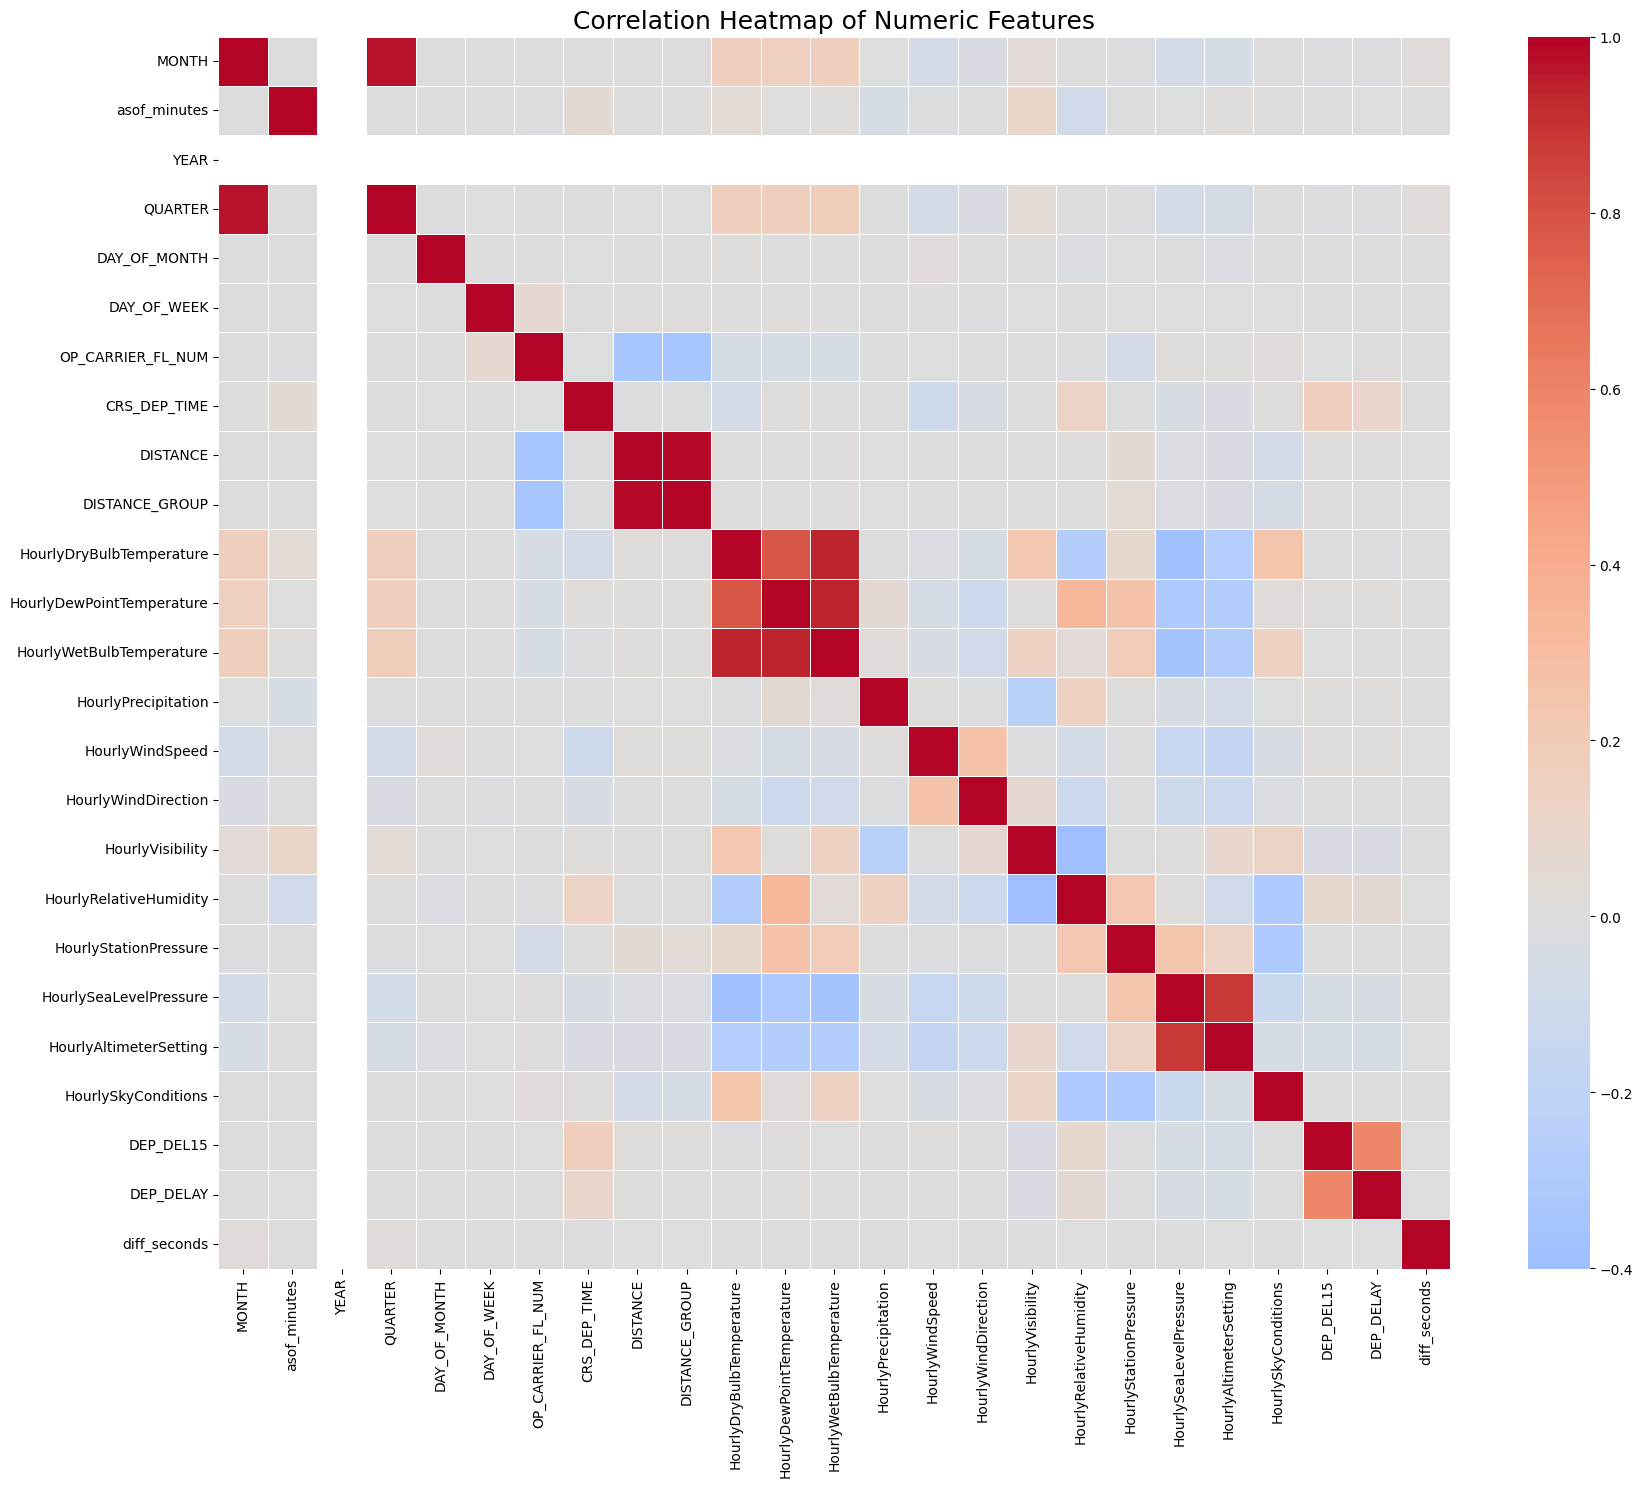

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    square=True,
    linewidths=.5
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=18)
plt.show()


Weather variables exhibit extremely weak linear correlations with departure delay, suggesting that delay patterns are complex and likely nonlinear.

In [0]:
target_corr = corr_matrix["DEP_DEL15"].sort_values(ascending=False)
target_corr


DEP_DEL15                    1.000000
DEP_DELAY                    0.582083
CRS_DEP_TIME                 0.164870
HourlyRelativeHumidity       0.072186
HourlyPrecipitation          0.023588
DISTANCE                     0.018944
DISTANCE_GROUP               0.018936
HourlyDewPointTemperature    0.017204
HourlyWindSpeed              0.016969
HourlyWindDirection          0.008637
HourlySkyConditions          0.006143
asof_minutes                 0.003639
DAY_OF_MONTH                 0.001916
DAY_OF_WEEK                 -0.000258
HourlyWetBulbTemperature    -0.001029
OP_CARRIER_FL_NUM           -0.001289
diff_seconds                -0.001330
HourlyStationPressure       -0.006325
MONTH                       -0.018441
QUARTER                     -0.020721
HourlyDryBulbTemperature    -0.021218
HourlyVisibility            -0.036456
HourlySeaLevelPressure      -0.048642
HourlyAltimeterSetting      -0.057964
YEAR                              NaN
Name: DEP_DEL15, dtype: float64

To assess linear relationships among numerical variables and departure delay, we computed a full correlation matrix and visualized it using a heatmap. As expected, DEP_DEL15 is highly correlated with DEP_DELAY, since the 15-minute delay indicator is derived directly from delay minutes. Beyond that, nearly all features show very weak linear correlation with delay outcomes. Most weather variables fall between –0.05 and +0.05, indicating negligible linear influence. Scheduled departure time (CRS_DEP_TIME) shows a mild positive relationship, reflecting the tendency for late-day flights to experience higher delays. Overall, the heatmap suggests that delays are driven by nonlinear, interaction-based dynamics rather than simple linear predictors, validating the need for machine learning models instead of linear baselines.

In [0]:
import pyspark.sql.functions as F

origin_delay_pct = (
    df_clean_1y
    .groupBy("ORIGIN")
    .agg(F.mean("DEP_DEL15").alias("pct_delayed"))
    .orderBy(F.desc("pct_delayed"))
)

origin_delay_pct.show(20, truncate=False)


+------+-------------------+
|ORIGIN|pct_delayed        |
+------+-------------------+
|ADK   |0.3877551020408163 |
|HYA   |0.37349397590361444|
|OTH   |0.3490304709141274 |
|OGD   |0.33653846153846156|
|HGR   |0.2967032967032967 |
|MMH   |0.2926829268292683 |
|OWB   |0.27722772277227725|
|SWF   |0.27014492753623187|
|MEI   |0.2690677966101695 |
|ACK   |0.2668977469670711 |
|BQN   |0.265234546251644  |
|MDW   |0.265201966764175  |
|LCK   |0.26459143968871596|
|ASE   |0.26364692218350755|
|PPG   |0.25833333333333336|
|EWR   |0.2545327912909844 |
|STC   |0.25384615384615383|
|HTS   |0.2532188841201717 |
|BLV   |0.251984126984127  |
|ORH   |0.25165562913907286|
+------+-------------------+
only showing top 20 rows


In [0]:
df = spark.read.parquet("dbfs:/student-groups/Group_4_4/data_12M/df_joined_1Y_2015_features.parquet/")
df.printSchema()
df.show(5)

root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWi

In [0]:
import pyspark.sql.functions as F

carrier_delay = (
    df.groupBy("OP_CARRIER")
      .agg(F.mean("DEP_DEL15").alias("pct_delayed"))
      .orderBy(F.col("pct_delayed").desc())
)

display(carrier_delay)


OP_CARRIER,pct_delayed
F9,0.25741577171372526
B6,0.2562584550634728
EV,0.2183179903261039
WN,0.20703364513295802
AA,0.1994575013903285
UA,0.19409672106505987
YV,0.19213821366723183
G4,0.19092710856639505
OH,0.18967359851161206
NK,0.1857325614387902


In [0]:
import pyspark.sql.functions as F

df2 = df.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("int"))

hour_delay = (
    df2.groupBy("DEP_HOUR")
       .agg(F.mean("DEP_DEL15").alias("pct_delayed"))
       .orderBy("DEP_HOUR")
)

display(hour_delay)

DEP_HOUR,pct_delayed
0,0.19333915429711862
1,0.208551899539024
2,0.24846356453028973
3,0.23682983682983683
4,0.23090586145648312
5,0.06515574110781717
6,0.07118574850167217
7,0.0936739190808158
8,0.1115070088563792
9,0.13335960802513042


In [0]:
import pandas as pd

numeric_cols = [c for c, t in df.dtypes if t in ("double", "int", "bigint")]

correlations = []
for col in numeric_cols:
    try:
        corr_value = df.stat.corr("DEP_DEL15", col)
        correlations.append((col, corr_value))
    except:
        correlations.append((col, None))

corr_df = pd.DataFrame(correlations, columns=["feature", "corr_with_DEP_DEL15"])
corr_df = corr_df.sort_values("corr_with_DEP_DEL15", ascending=False)
corr_df

,feature,corr_with_DEP_DEL15
33,dep_delay15_24h_rolling_avg_by_origin_dayofweek,0.249206
31,dep_delay15_24h_rolling_avg_by_origin_carrier,0.202466
29,dep_delay15_24h_rolling_avg_by_origin,0.194676
32,dep_delay_24h_rolling_avg_by_origin_dayofweek,0.179136
7,CRS_DEP_TIME,0.165220
22,DEP_HOUR,0.164916
28,dep_delay_24h_rolling_avg_by_origin,0.161672
30,dep_delay_24h_rolling_avg_by_origin_carrier,0.155885
26,peak_travel_hour,0.134942
17,HourlyRelativeHumidity,0.071566
